In [ ]:
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Cargar datos y normalizar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
usr_folder = r'/content/drive/MyDrive/Big Data/Datamining/Practica/2025_Datasets_Datamining' # Albert

In [ ]:
#usr_folder = r'/content/drive/MyDrive/Master/Data Mining/Prácticas Data Mining/2025_Datasets_Datamining' # Wenjie#

In [ ]:
output_folder = usr_folder +  '/dataset_lite/Output'

In [ ]:
def to_float_list(value):
    # Se eliminan los corchetes "[" y "]" del principio y el final → usando strip("[]")
    # Se separan los números por el espacio en blanco →  usando split()
    # Se eliminan las comas sobrantes →  usando strip(',')
    # Se aplica la función float a cada elemento de la lista → usando map()
    return float(value.strip("[]").split()[0].strip(','))

# Se lee el CSV
df = pd.read_csv(output_folder + "/features_solas.csv")

# Las columnas "ship", "date" y "audio_path" no se procesan por la función to_float_list ya que no son valores float
converters = {col: to_float_list for col in df.columns if col not in ["ship", "date", "audio_path"]}

# Se lee el CSV aplicando los conversores
df = pd.read_csv(output_folder + "/features_solas.csv", converters=converters)
df.tail()

,ship,date,audio_path,zcr_1,zcr_2,zcr_3,zcr_4,zcr_5,zcr_6,zcr_7,...,delta2_mfcc_13_164,delta2_mfcc_13_165,delta2_mfcc_13_166,delta2_mfcc_13_167,delta2_mfcc_13_168,delta2_mfcc_13_169,delta2_mfcc_13_170,delta2_mfcc_13_171,delta2_mfcc_13_172,delta2_mfcc_13_173
2812,Cargo,20171215,/content/drive/MyDrive/Big Data/Datamining/Pra...,0.025391,0.035156,0.047852,0.051758,0.043457,0.051270,0.048828,...,0.848431,0.460462,0.206108,0.111823,-0.083997,-0.110537,-0.066474,-0.000142,-0.069333,-0.225826
2813,Cargo,20171215,/content/drive/MyDrive/Big Data/Datamining/Pra...,0.020508,0.033691,0.039062,0.031738,0.034180,0.034180,0.036133,...,-0.575876,-0.761920,-0.619396,-0.042054,0.191413,0.123859,-0.022374,0.023498,-0.031606,-0.043965
2814,Cargo,20171215,/content/drive/MyDrive/Big Data/Datamining/Pra...,0.011230,0.033691,0.052246,0.061035,0.063477,0.050781,0.038086,...,0.026764,-0.740635,-0.895193,-0.223999,0.363778,0.528912,0.247174,-0.085360,-0.148452,-0.327690
2815,Cargo,20171215,/content/drive/MyDrive/Big Data/Datamining/Pra...,0.024414,0.036621,0.058594,0.054688,0.044922,0.034668,0.015625,...,0.132078,-0.014066,-0.301698,0.204140,0.610491,0.426699,0.303088,-0.072504,-0.470858,-0.541813
2816,Cargo,20171215,/content/drive/MyDrive/Big Data/Datamining/Pra...,0.009277,0.022461,0.032227,0.034180,0.044922,0.041992,0.036621,...,0.115618,0.214094,0.182937,0.170767,0.157205,0.190524,-0.199536,0.092588,0.194965,0.074405


In [ ]:
## Normalizar los datos con RobustScaler
# Seleccionar solo las columnas numéricas
numerical_cols = df.select_dtypes(include=['number']).columns

# Inicializar y aplicar RobustScaler
scaler = RobustScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Separar los datos

In [ ]:
df["ship"].value_counts()

,count
ship,
Tanker,1088
Passengership,889
Cargo,520
Tug,320


In [ ]:
## Separación el dataframe según las características "X" y el target "y".
X = df.drop(columns=["date", "audio_path", "ship"]) # Se quita el target y las caracerísticas que no se tienen que analizar

# El target es adivinar el barco.
y = df["ship"]

# División estratificada para mantener la proporción de clases en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=23, stratify=y)

# Verificar la proporción de clases en train y test
print("Proporción en train:")
print(y_train.value_counts(normalize=True))

print("Proporción en test:")
print(y_test.value_counts(normalize=True))

Proporción en train:
ship
Tanker           0.386098
Passengership    0.315576
Cargo            0.184678
Tug              0.113648
Name: proportion, dtype: float64
Proporción en test:
ship
Tanker           0.386525
Passengership    0.315603
Cargo            0.184397
Tug              0.113475
Name: proportion, dtype: float64


# Entrenamiento

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
RF = RandomForestClassifier(max_depth=20, n_estimators = 200, random_state=0)
RF.fit(X_train, y_train)
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# Resultados

In [ ]:
# Accuracy
print("Accuracy - Datos de train: {} " .format(accuracy_score(y_train, y_train_pred)))
print("Accuracy - Datos de test: {} ". format(accuracy_score(y_test, y_test_pred)))

Accuracy - Datos de train: 1.0 
Accuracy - Datos de test: 0.6477541371158393 


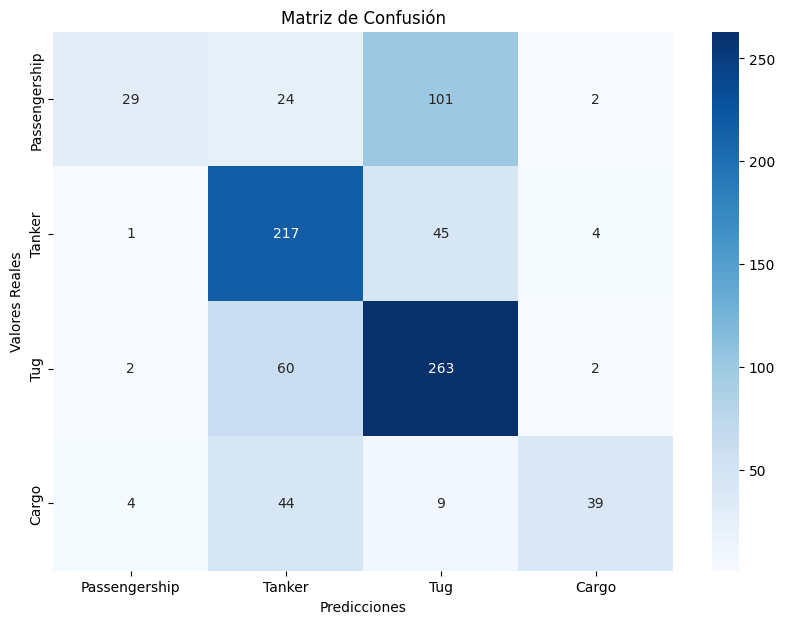

In [ ]:
# Crear la gráfica de la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
labels = y_test.unique()

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

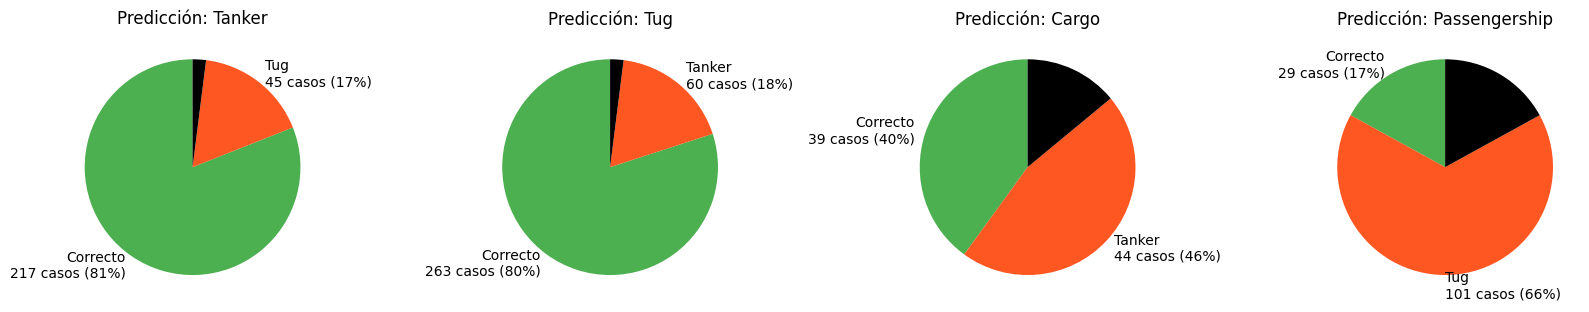

In [ ]:
data = {
    "Tanker": {"Correcto": (217, 81), "Tug": (45, 17)},
    "Tug": {"Correcto": (263, 80), "Tanker": (60, 18)},
    "Cargo": {"Correcto": (39, 40), "Tanker": (44, 46)},
    "Passengership": {"Correcto": (29, 17), "Tug": (101, 66)}
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, (category, values) in zip(axes, data.items()):
    total = 100
    used_percentage = sum(val[1] for val in values.values())
    other_percentage = total - used_percentage

    labels = [f"{key}\n{val[0]} casos ({val[1]}%)" for key, val in values.items()]
    labels.append("")  # Empty label for the black segment

    sizes = [val[1] for val in values.values()]
    sizes.append(other_percentage)

    colors = ["#4CAF50", "#FF5722", "black"]

    ax.pie(sizes, labels=labels, autopct="", startangle=90, colors=colors)
    ax.set_title(f"Predicción: {category}")

plt.tight_layout()
plt.show()

Feature importances Random forest: [1.17091473e-04 2.06327427e-04 3.60020209e-04 ... 2.85886265e-05
 2.96307221e-05 4.48571984e-05]


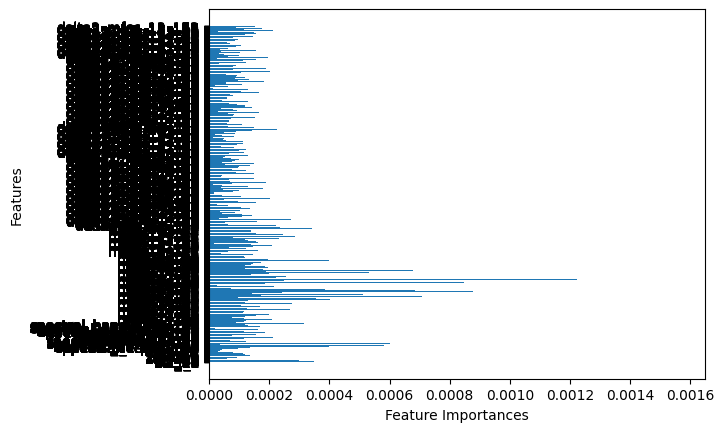

In [ ]:
# Gráfica de las features
number_of_features = list(range(X_train.shape[1]))
print("Feature importances Random forest:", RF.feature_importances_)
plt.barh(number_of_features, RF.feature_importances_)
plt.yticks(number_of_features, X.columns)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()

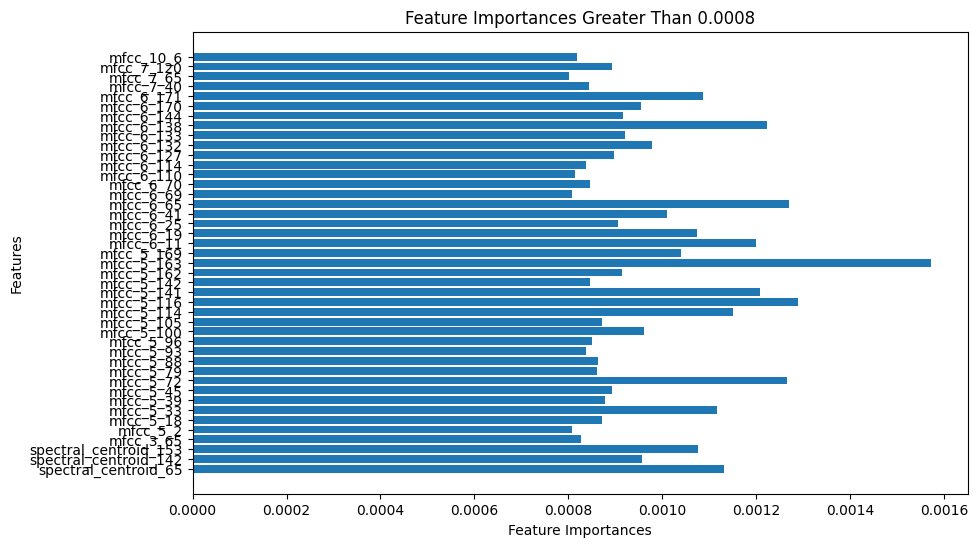

In [ ]:
# Obtener las importancias de las características
importances = RF.feature_importances_

# Filtrar las características con una importancia mayor a 0.0008
filtered_indices = [i for i, imp in enumerate(importances) if imp > 0.0008]

# Crear las listas de características y sus importancias filtradas
filtered_features = [X.columns[i] for i in filtered_indices]
filtered_importances = [importances[i] for i in filtered_indices]

# Graficar solo las características filtradas
plt.figure(figsize=(10, 6))
plt.barh(filtered_features, filtered_importances)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.title("Feature Importances Greater Than 0.0008")
plt.show()


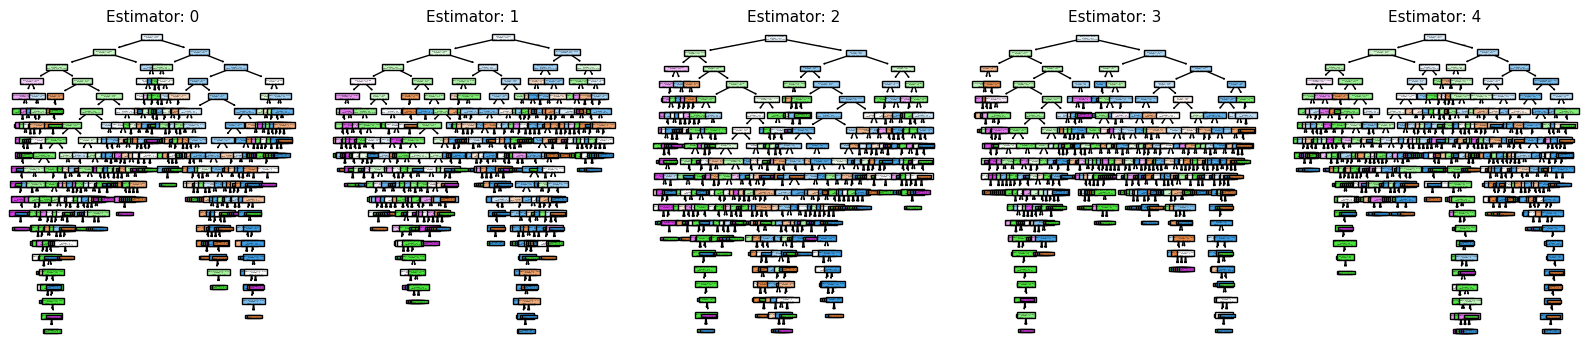

In [ ]:
# Gráfica de los árboles
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (20,4))
for index in range(0, 5):
    tree.plot_tree(RF.estimators_[index],
                   feature_names = X.columns,
                   filled = True,
                   impurity=False,
                   ax = axes[index]);


    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

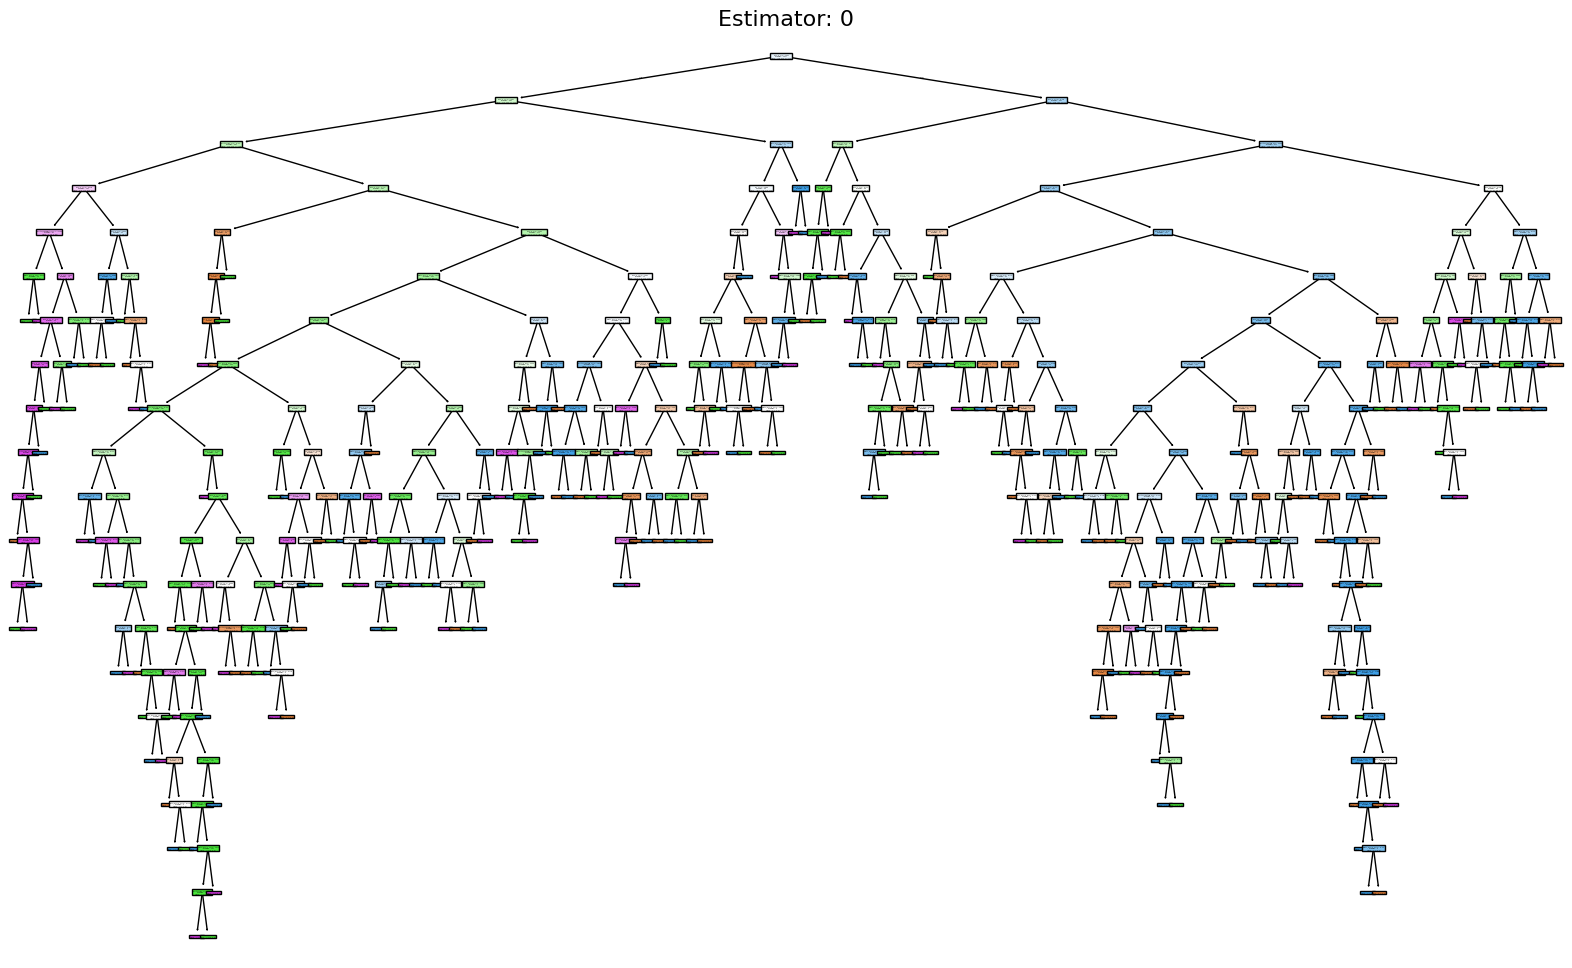

In [ ]:
# Seleccionar un solo árbol para mostrar
fig, ax = plt.subplots(figsize=(20, 12))  # Aumentar el tamaño de la figura
tree.plot_tree(RF.estimators_[0],  # Solo mostrar el primer estimador
               feature_names=X.columns,
               filled=True,
               impurity=False,
               ax=ax)

ax.set_title('Estimator: 0', fontsize=16)
plt.show()

In [ ]:
# Obtener los resultados de precisión, recall y f1-score
report = classification_report(y_test, y_test_pred)

# Mostrar el reporte
print(report)

{'Cargo': {'precision': 0.8888888888888888, 'recall': 0.23809523809523808, 'f1-score': 0.3755868544600939, 'support': 168.0}, 'Passengership': {'precision': 0.6329113924050633, 'recall': 0.78125, 'f1-score': 0.6993006993006993, 'support': 256.0}, 'Tanker': {'precision': 0.6348837209302326, 'recall': 0.8272727272727273, 'f1-score': 0.718421052631579, 'support': 330.0}, 'Tug': {'precision': 0.7636363636363637, 'recall': 0.45652173913043476, 'f1-score': 0.5714285714285714, 'support': 92.0}, 'accuracy': 0.6560283687943262, 'macro avg': {'precision': 0.7300800914651371, 'recall': 0.5757849261246, 'f1-score': 0.5911842944552359, 'support': 846.0}, 'weighted avg': {'precision': 0.6987291053789028, 'recall': 0.6560283687943262, 'f1-score': 0.6285696767259155, 'support': 846.0}}


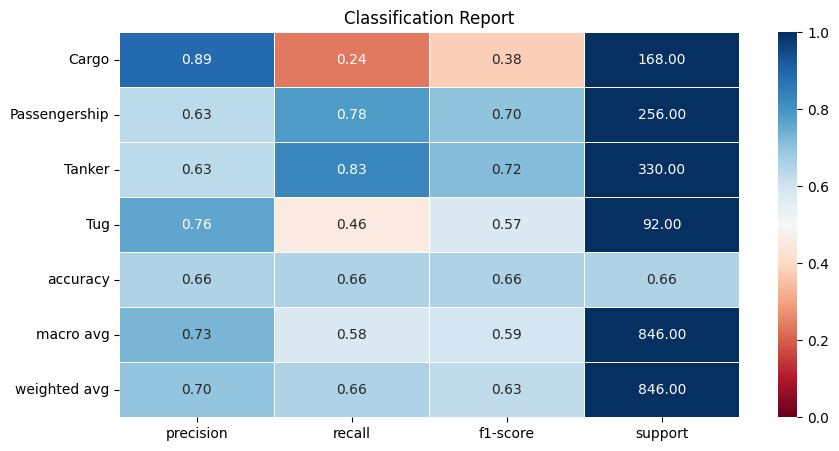

In [ ]:
 # Mostrar el reporte de forma más visual
def visual_classification_report(y_test, y_test_pred):
  report = classification_report(y_test, y_test_pred, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  plt.figure(figsize=(10, 5))
  sns.heatmap(report_df, annot=True, cmap="RdBu", fmt=".2f", linewidths=.5,
  vmin=0, vmax=1)
  plt.title('Classification Report')
  plt.show()

 visual_classification_report(y_test, y_test_pred)

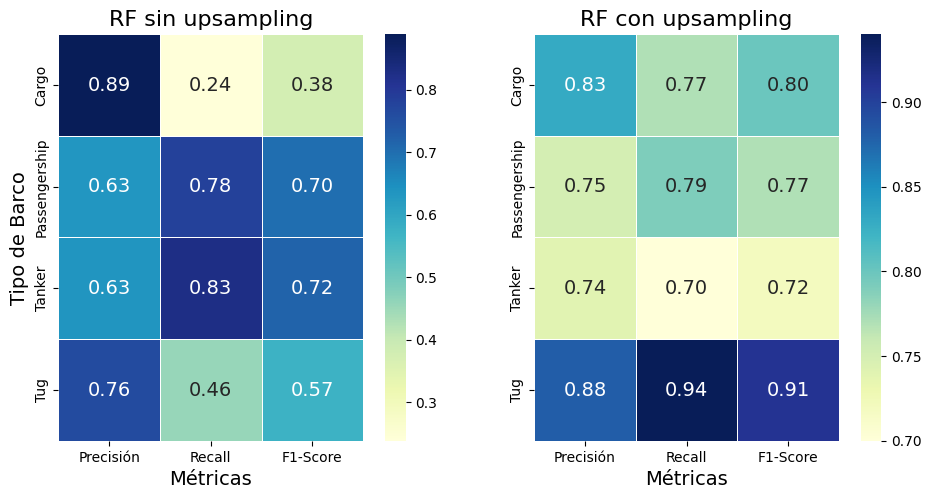

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Datos organizados en matrices separadas para cada modelo
data_modelo_1 = np.array([
    [0.8889, 0.2381, 0.3756],  # Cargo
    [0.6329, 0.7813, 0.6993],  # Passengership
    [0.6349, 0.8273, 0.7184],  # Tanker
    [0.7636, 0.4565, 0.5714]   # Tug
])

data_modelo_2 = np.array([
    [0.83, 0.77, 0.80],
    [0.75, 0.79, 0.77],
    [0.74, 0.70, 0.72],
    [0.88, 0.94, 0.91]
])

# Etiquetas de columnas y filas
metricas = ['Precisión', 'Recall', 'F1-Score']
barcos = ['Cargo', 'Passengership', 'Tanker', 'Tug']

# Crear subplots para los dos heatmaps
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Se reduce el tamaño del gráfico

# Parámetros para mejorar la visualización
heatmap_params = {
    "annot": True,         # Mostrar valores en celdas
    "cmap": "YlGnBu",      # Esquema de colores
    "fmt": ".2f",          # Formato de los valores
    "xticklabels": metricas,
    "yticklabels": barcos,
    "annot_kws": {"size": 14},  # Tamaño de los números en las celdas
    "linewidths": 0.5,     # Separación entre celdas
    "square": True         # Mantener celdas cuadradas
}

# Heatmap para Modelo Diseño 1
sns.heatmap(data_modelo_1, ax=axes[0], **heatmap_params)
axes[0].set_title("RF sin upsampling", fontsize=16)
axes[0].set_xlabel("Métricas", fontsize=14)
axes[0].set_ylabel("Tipo de Barco", fontsize=14)

# Heatmap para Modelo Diseño 2
sns.heatmap(data_modelo_2, ax=axes[1], **heatmap_params)
axes[1].set_title("RF con upsampling", fontsize=16)
axes[1].set_xlabel("Métricas", fontsize=14)
axes[1].set_ylabel("")

# Ajustar diseño
plt.tight_layout()
plt.show()


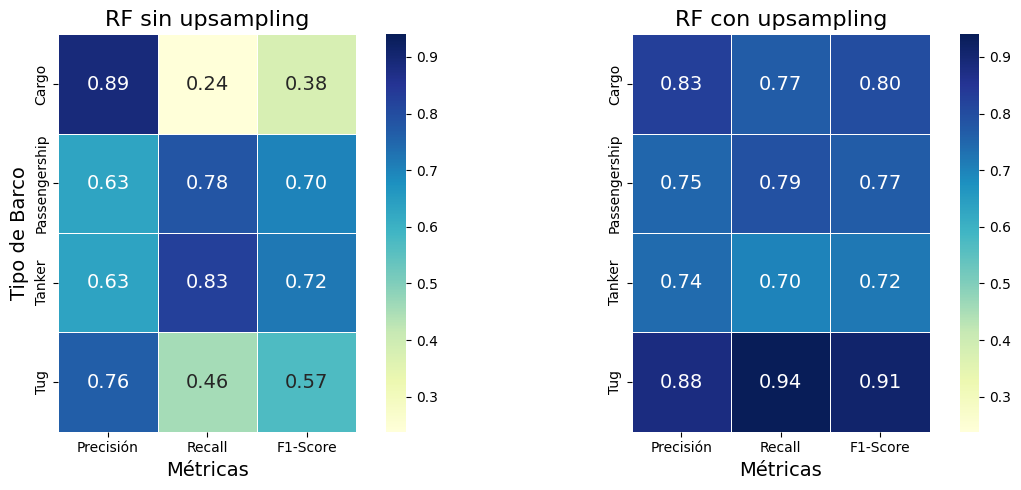

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Datos organizados en matrices separadas para cada modelo
data_modelo_1 = np.array([
    [0.8889, 0.2381, 0.3756],  # Cargo
    [0.6329, 0.7813, 0.6993],  # Passengership
    [0.6349, 0.8273, 0.7184],  # Tanker
    [0.7636, 0.4565, 0.5714]   # Tug
])

data_modelo_2 = np.array([
    [0.83, 0.77, 0.80],
    [0.75, 0.79, 0.77],
    [0.74, 0.70, 0.72],
    [0.88, 0.94, 0.91]
])

# Obtener valores mínimo y máximo de ambas matrices para normalizar la escala de color
vmin = min(data_modelo_1.min(), data_modelo_2.min())
vmax = max(data_modelo_1.max(), data_modelo_2.max())

# Etiquetas de columnas y filas
metricas = ['Precisión', 'Recall', 'F1-Score']
barcos = ['Cargo', 'Passengership', 'Tanker', 'Tug']

# Crear subplots para los dos heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Se ajusta el tamaño

# Parámetros comunes del heatmap
heatmap_params = {
    "annot": True,         # Mostrar valores
    "cmap": "YlGnBu",      # Esquema de colores
    "fmt": ".2f",
    "xticklabels": metricas,
    "yticklabels": barcos,
    "annot_kws": {"size": 14},  # Tamaño del texto dentro de las celdas
    "linewidths": 0.5,     # Bordes entre celdas
    "square": True,        # Celdas cuadradas
    "vmin": vmin,          # Fijar el valor mínimo en la escala de color
    "vmax": vmax           # Fijar el valor máximo en la escala de color
}

# Heatmap para Modelo Diseño 1
sns.heatmap(data_modelo_1, ax=axes[0], **heatmap_params)
axes[0].set_title("RF sin upsampling", fontsize=16)
axes[0].set_xlabel("Métricas", fontsize=14)
axes[0].set_ylabel("Tipo de Barco", fontsize=14)

# Heatmap para Modelo Diseño 2
sns.heatmap(data_modelo_2, ax=axes[1], **heatmap_params)
axes[1].set_title("RF con upsampling", fontsize=16)
axes[1].set_xlabel("Métricas", fontsize=14)
axes[1].set_ylabel("")

# Ajustar diseño
plt.tight_layout()
plt.show()


# Pruebas con distintos hiperparámetros

In [ ]:
param_grid = {
    'max_depth': [10, 20, 30, None],
    'n_estimators': [50, 100, 200, 300]}

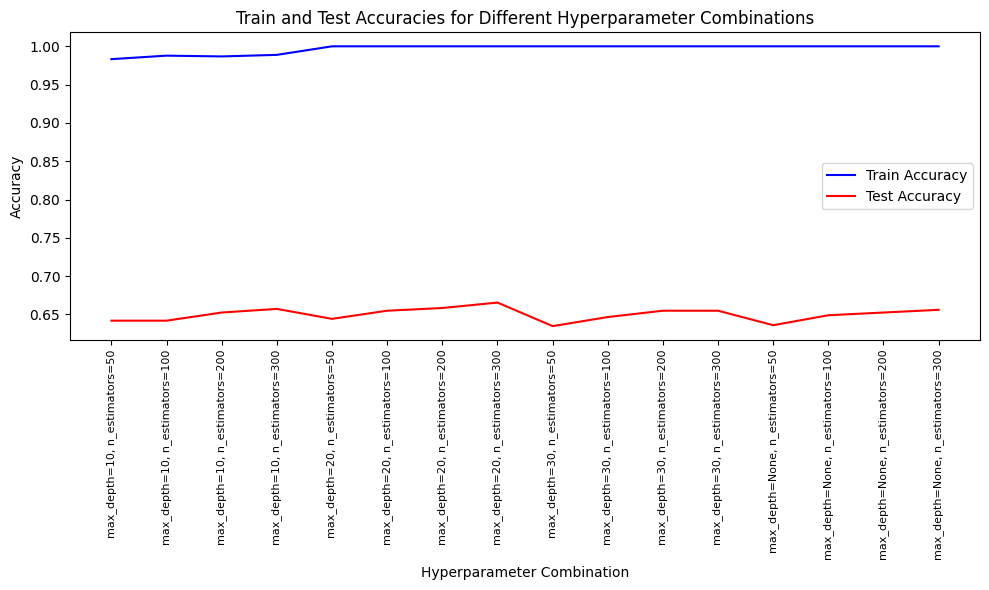

In [ ]:
# Crear listas para almacenar las accuracies
train_accuracies = []
test_accuracies = []
param_combinations = []  # Lista para almacenar las combinaciones de parámetros

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=23)

# Realizar un bucle sobre todas las combinaciones de los parámetros
for max_depth in param_grid['max_depth']:
    for n_estimators in param_grid['n_estimators']:
        # Crear el modelo con los parámetros actuales
        RF = RandomForestClassifier(
            max_depth=max_depth,
            n_estimators=n_estimators,
            random_state=23
        )

        # Entrenar el modelo
        RF.fit(X_train, y_train)

        # Predecir
        y_train_pred = RF.predict(X_train)
        y_test_pred = RF.predict(X_test)

        # Calcular las accuracies
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Almacenar las accuracies
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Almacenar la combinación de parámetros
        param_combinations.append(f"max_depth={max_depth}, n_estimators={n_estimators}")

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_accuracies)), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(len(test_accuracies)), test_accuracies, label="Test Accuracy", color='red')
plt.xticks(ticks=range(len(param_combinations)), labels=param_combinations, rotation=90, fontsize=8)
plt.xlabel("Hyperparameter Combination")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train and Test Accuracies for Different Hyperparameter Combinations")
plt.tight_layout()  # Ajustar el diseño para evitar solapamiento de etiquetas
plt.show()